In [2]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
import nlopt
from matplotlib import pyplot as plt
from meep import Animate2D
from autograd import tensor_jacobian_product
from matplotlib.patches import Circle

mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

## geometry
resolution = 10  # pixels/um
sx = 6.2  # size of cell in X direction
sy = 0.4 # size of cell in Y direction
cell = mp.Vector3(sx, sy, 0)
dpml = 1.0
pml_layers = [mp.PML(dpml,direction=mp.X)]

y_loc = 0

design_region_width = 3
design_region_height = sy
design_region_resolution = 10
design_region_resolution = int(1 * resolution)
#Nx =   int(design_region_resolution * design_region_width) + 1
Nx = 5
Ny =  1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(0,y_loc), size=mp.Vector3(design_region_width, design_region_height))
)


geometry = [
     mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]

## source 
fcen = 2
width = 0.4
fwidth = width * fcen
source_center = [-2, y_loc, 0]
source_size = mp.Vector3(0, sy, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

##
sim = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
    k_point = mp.Vector3(0, 0, 0) # periodical BCs
)

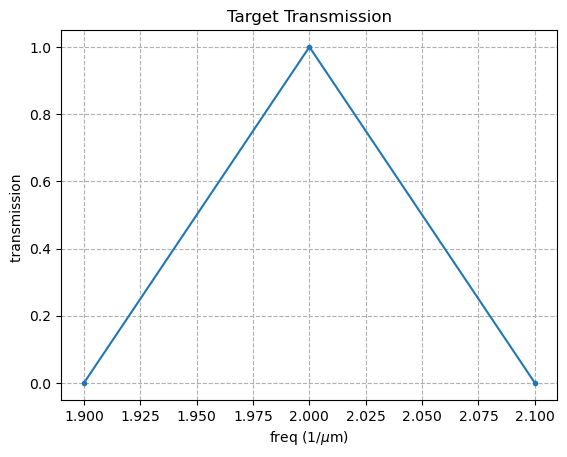

In [3]:
##
Nf = 3
frequencies = np.linspace(1.9, 2.1, Nf) # freqs 
def T_target(freq):
    l = len(freq)
    output = np.zeros(l)
    df = 0.04
    ids = np.argwhere(np.abs(freq-2)<df).flatten()
    output[ids] = 1
    return output
trans = T_target(frequencies)
plt.figure()
plt.plot(frequencies, trans,'.-')
plt.title('Target Transmission')
plt.xlabel('freq (1/$\mu$m) ')
plt.ylabel('transmission ')

# Display grid
plt.grid(True,linestyle='dashed')
plt.show()

In [4]:
##

TE_right = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(2,  y_loc, 0), size=mp.Vector3(y=sy)), mode=1
)

TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(-1.8, y_loc, 0), size=mp.Vector3(y=sy)), mode=1
)

ob_list = [TE0, TE_right]


def J(source, right):    
    #cost = - (npa.abs(right / source) ** 2 - trans)**2
    cost =  npa.abs(right / source) ** 2 
    
    return npa.mean(cost)




opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies
)

minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)
print(resolution)

0.20124611797498096
10


In [5]:
def mapping(x, eta, beta):

    # filter
#    filtered_field = mpa.conic_filter(
#        x,
#        filter_radius,
#        design_region_width,
#        design_region_height,
#        design_region_resolution,
#    )

    # projection
    projected_field = mpa.tanh_projection(x, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

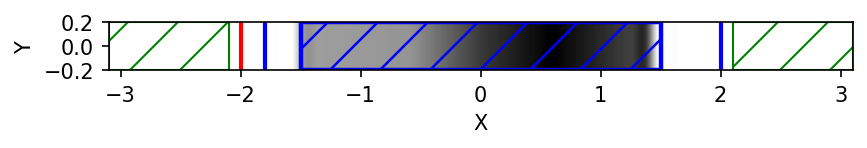

In [7]:
%matplotlib inline
plt.figure(dpi=150)
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([rho_vector])
opt.plot2D(True, output_plane=mp.Volume(center=(0, 0), size=(sx, sy)))

In [6]:
evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])  # compute objective and gradient

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

Current iteration: 73
Starting forward run...


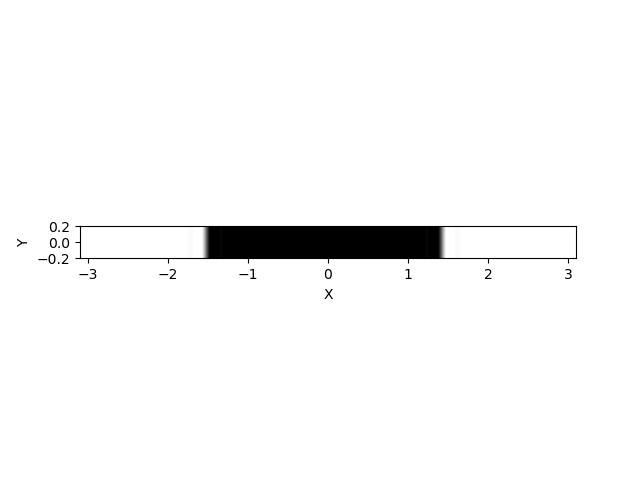

Starting adjoint run...
Calculating gradient...
Current iteration: 74
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 75
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 76
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 77
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 78
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 79
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 80
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 81
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 82
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iteration: 83
Starting forward run...
Starting adjoint run...
Calculating gradient...
Current iter

In [ ]:
%matplotlib ipympl

# Create the animation
animate = Animate2D(
    fields=None,
    realtime=True,
    eps_parameters={'contour': False, 'alpha': 1},
    plot_sources_flag=False,
    plot_monitors_flag=False,
    plot_boundaries_flag=False,
    update_epsilon=True,  # required for the geometry to update dynamically
    nb=True         # required if running in a Jupyter notebook
)
# This will trigger the animation at the end of each simulation
opt.step_funcs=[mp.at_end(animate)]

algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 2
num_betas = 6
update_factor = 12
for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

In [8]:
animate.to_jshtml(fps=5)

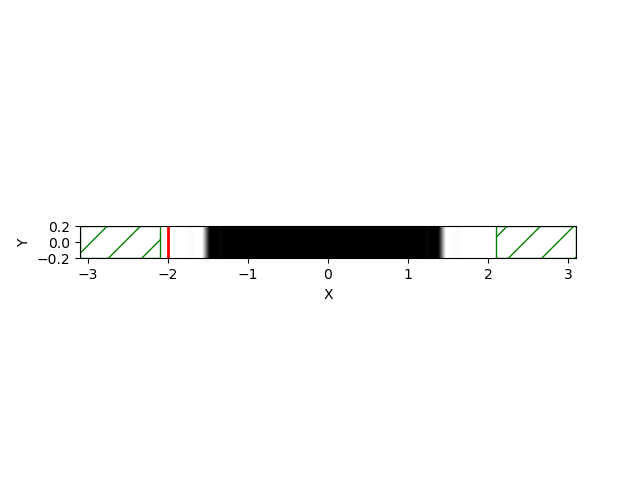

In [9]:
## update the epsilon weight with the optimized x
design_variables.update_weights(x-rho_vector)
##
geometry = [
     mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]
##
## source 
src = [
    mp.Source(
        mp.ContinuousSource(frequency=fcen),
        component=mp.Ez,
        center=mp.Vector3(-2, y_loc, 0),
        size=mp.Vector3(0, sy, 0),
    )
]

##
sim_opt = mp.Simulation(
    cell_size=cell,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=src,
    eps_averaging=False,
    resolution=resolution,
)
##
plt.figure()
sim_opt.plot2D()
plt.show()

In [27]:
## animation
import mycmapls as ms# colormap defined in mycmapls.py

f = plt.figure(dpi=100)
Animate = mp.Animate2D(fields=mp.Ez, f=f, realtime=False, normalize=True
                      , field_parameters={'alpha':1,'cmap':ms.bifan})
plt.close()
sim_opt.run(mp.at_every(0.5, Animate), until=300)
plt.close()
filename = "film_id.mp4"
Animate.to_mp4(10, filename)

FloatProgress(value=0.0, description='0% done ', max=300.0)

In [16]:
x-rho_vector

array([8.17783341e-14, 9.98368055e-14, 1.59650071e-13, 2.77555756e-17,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.87276886e-13, 5.54278845e-14, 1.58234537e-13])

In [15]:
rho_vector

array([0.01001574, 0.23702862, 0.55959252, 0.20210606, 0.6050672 ,
       0.77110193, 0.82814072, 0.5951551 , 0.52809024, 0.88942442,
       0.90300216, 0.68306669, 0.55749237, 0.46692781, 0.82125623,
       0.15931522, 0.3947043 , 0.73332791, 0.87307675, 0.08911657,
       0.24329577, 0.02738348, 0.38869036, 0.65414775, 0.49608153,
       0.98236846, 0.58289844, 0.85163072, 0.53266397, 0.22721493,
       0.16717683])